### Disclaimer
This article describes a way in which a seemingly reasonable thing to do can be problematic. I largely just wanted to show an interesting effect that might be worth considering when conducting A/B tests, and to conduct a basic investigation into the causes and potential corrections.

# Optimistic Bias in A/B testing

Let's present an all too common scenario in data science for business. You have several potential actions that you believe may be beneficial for your business goals but are unsure of which to take. Maybe this action is which model to roll out into production. Being a good data scientist, you decide to run an experiment to determine which action to take.

Running these experiments is expensive, so you carefully plan the experiment to use the minimum number of samples possible. You run the experiment and gather data. Once the experiment is concluded, you calculate summary statistics and present them to stakeholders. Maybe as part of this, you run some hypothesis tests, but ultimately you suggest the action with the highest expected benefit to business (why wouldn't you). You recommend this to the stakeholders and give them this expected value. Trusting their data team, your company enacts your recommendation and chooses this action.

6 months later, the true business value of this action is calculated and is lower than what you predicted. Oh, dear.


## Why did I overestimate?

Now, we live in a random world. There is always a chance that you overestimated due to stochastic effects that you couldn't avoid (in fact, we might naively expect to do so 50% of the time). However, in the set-up I have described, you have biased your estimation in a way that makes your estimate of the business value for your suggested action statistically more likely to be optimistic of the truth.


Informally, you have used this experiment to do two things.

1.   You have used the data to predict which of the actions has the highest mean.
2.   You have used the data to predict the mean of that action.

Now, I will not argue that either of these things individually is unreasonable. This issue comes in doing both at the same time. 



[Note, when I talk about 'expected values' I'm largely referring to mean values.]

## Theoretical Reasoning 

Let us assume that we are at least able to calculate an unbiased estimate of value for each of the actions. Assuming a continuous outcome variable with normal error this implies that the estimate of value $\mu^{pred}_i$ for each action $i$ can be described by


 <center>
$
  \mu^{pred}_i = \mu_i + \epsilon_i\,.
$

$
  \epsilon_i \sim \mathcal{N}(0,\,\sigma_i^{2})\,.
$
 </center>

Note that $\sigma_i$ will decrease as the number of samples per arm increases.

If your decision process is to choose the action $j$ such that 
<center> $j = argmax_i$   $\mu^{pred}_i$ </center> 
then you are maximising not only $\mu_j$ but also $\epsilon_j$. In other words, you are not only selecting based on a high true value but also for $i$ such that $ϵ_i>0$. 

<b>We are preferentially selecting for overestimation</b>




# Simulation to show this result
Let's first get some imports and choose a seed.


In [164]:
# Imports

import scipy.stats

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from math import ceil
from sys import exit
from matplotlib.ticker import MaxNLocator
from scipy import integrate

np.random.seed(123)
np.set_printoptions(precision=3)


Next, a simple class that can be used to simulate experimental results from an A/B test with a number of arms equal to the number of potential actions that we could take. The values for each sample are normally distributed around the true mean for that action ('means') with variance 'vars'.


In [165]:
# Data Generator
class DataGenerator():
    def __init__(self, means: list, vars: list) -> None:
        self.means = means
        self.vars = vars
        self.sanity_check()
        self.num_arms = len(self.means)

    def sanity_check(self):
        """
        Ensures that the number of arms is consistent
        """
        assert len(self.means) == len(self.vars) > 0
        for element in self.vars:
            assert element > 0

    def generate(self, num_samples=10):
        """
        :param num_samples: The number of samples that will be gathered per arm of the experiment
        :return: array (num_arms, num_samples): Samles from a ranndom normal distribution
        """
        samples = np.random.multivariate_normal(self.means, np.diag(self.vars), num_samples)
        return samples


num_samples = 10
DG = DataGenerator(means=[0.0, 0.3], vars=[0.5, 1.0])
DG.generate(num_samples=num_samples)

array([[ 0.705, -0.786],
       [-1.065,  0.583],
       [ 1.168, -0.279],
       [-0.303, -2.127],
       [-0.613,  1.566],
       [-0.067, -0.379],
       [-0.452,  1.791],
       [-0.307, -0.144],
       [ 1.546,  2.506],
       [ 0.273,  1.304]])

Okay, now let's build up our first potential way of selecting an action/arm. Again, we need to both predict an optimal action, and the expected value for that action.

We'll also select some way of breaking ties. I choose to do this at random; feel free to amend this (ties are very unlikely to occur so it doesn't make a difference).



In [166]:
def randargmax(vector):
    """
    Returns a random argument of the vector which is one of the maximum possible values of that vector.
    :param vector:
    :return:
    """
    return np.argmax(np.random.random(vector.shape) * (vector == vector.max()))

tie_breaker = randargmax

def jitter(center, num_samples):
   """
   A function for plotting
   """
   return np.random.normal(center, 0.02, num_samples)




We'll also make a super-class for selectors just to contain the plotting functionality. We want to be able to show a plot with the true means as black lines, the samples as black dots, and the selected action/predicted value in red. We'll also show the sample means for all arms in blue for comparison.    

In [167]:
class BaseSelector():
  def __init__(self, name='unnamed') -> None:
    self.name = name
  

  def select_predict_plot(self, samples, data_generator=None):
    ax = plt.figure().gca()

    sp_op = getattr(self, "select_predict", None)
    if callable(sp_op):
      best_arm, pred_val = sp_op(samples)
    else:
      exit("No select_predict method, do not use super alone.")



    for idx, values in enumerate(samples.T):
      plt.scatter(jitter(idx, num_samples), values)
      plt.hlines(np.mean(values), idx-0.1, idx+0.1, colors='blue')
      if data_generator is not None:
        plt.hlines(data_generator.means[idx], idx - 0.1, idx + 0.1,
                   colors='black')
    
    plt.hlines(pred_val, best_arm - 0.1, best_arm + 0.1,
               colors='red', linewidth=4.0)
    
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))


    plt.xlabel('Arm')
    plt.ylabel('Metric')
    plt.title('Single selection for this data generator')
    plt.show()
    return best_arm, pred_val

Now let's formalise the <i>NaiveAB</i> selector, which is the approach toward selection and prediction described above. Specifically, we calculate the sample mean for each of the actions/arms, select the action/arm with the largest calculated sample mean and then predict the calculated sample mean as the true expected value for that action.

In [168]:
class NaiveAB(BaseSelector):
  """
  A simple selection rule
  1. Chooses the arm with the maximum sample mean
  2. Predicts the sample mean for that arm
  """
  def __init__(self, name='NaiveAB'):
        super().__init__(name)
  
  def select_predict(self, samples: np.ndarray) -> (int, float):
    """
    Predicts the best arm and the value for that arm.
    """
    pred_means = np.mean(samples, axis=0)
    pred_best_arm = tie_breaker(pred_means)
    pred_val = pred_means[pred_best_arm]

    return pred_best_arm, pred_val
  

We'll run one simulated A/B test with two arms, the first arm has true expected value 0.0 and the second has true expected value 1.0. Both have variance 1.0.

In [169]:
selector = NaiveAB()
DG = DataGenerator(means=[0.0, 1.0], vars=[1.0, 1.0])
samples = DG.generate(num_samples=num_samples)
print(f'Samples: {samples}')

best_arm, pred_val = selector.select_predict(samples)
print(f'Under selection rule {selector.name}, for this sample we choose action {best_arm} and predict expected value {pred_val :.3f} (actions counted from 0) ')

Samples: [[ 0.737  2.491]
 [-0.936  2.176]
 [-1.254  0.362]
 [ 0.907 -0.429]
 [-0.14   0.138]
 [-0.256 -1.799]
 [-1.772  0.3  ]
 [ 0.927  0.826]
 [ 0.003  1.688]
 [-0.88   1.284]]
Under selection rule NaiveAB, for this sample we choose action 1 and predict expected value 0.704 (actions counted from 0) 


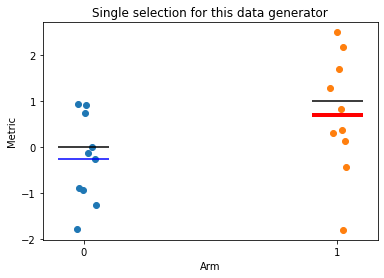

(1, 0.7038121986454556)

In [170]:
selector.select_predict_plot(samples, DG)

If you are using the same seed as me, you'll have got

<i> 'Under selection rule NaiveAB, for this sample we choose action 1 and predict expected value 0.704 (actions counted from 0) ' </i>

Which is actually an underestimation. Oh dear, so far not that convincing to you. Let's try an interesting case, where both actions have the same true expected value. We'll set this to expected value to 0.0 for simplicity.


Under selection rule NaiveAB, for this sample we choose action 1 and predict expected value 1.089 (actions counted from 0) 


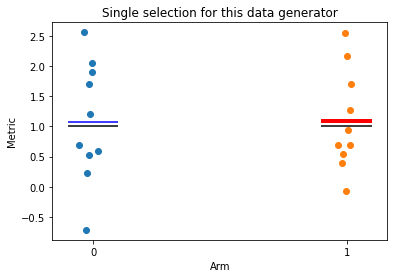

(1, 1.0885187724723355)

In [171]:
np.random.seed(123) 
DG = DataGenerator(means=[1.0, 1.0], vars=[0.5, 0.5])
samples = DG.generate(num_samples=num_samples)
best_arm, pred_val = selector.select_predict(samples)
print(f'Under selection rule {selector.name}, for this sample we choose action {best_arm} and predict expected value {pred_val :.3f} (actions counted from 0) ')
selector.select_predict_plot(samples, DG)


Well there we go, a case where our predicted value is an overestimation. In fact, in the above example, we would expect an overestimation precisely 75% of the time. For inuitive reasoning, given that the estimation errors will be symmetrically distributed, there are 4 equally likely outcomes. 


1.   $ϵ_0 >0, ϵ_1 >0$, (both overestimated)
2.   $ϵ_0 >0, ϵ_1 < 0$, ($\mu^{pred}_0$ overestimated and chosen, $\mu^{pred}_1$ underestimated)
3.   $ϵ_0 < 0, ϵ_1 >0$, ($\mu^{pred}_0$ underestimated, $\mu^{pred}_1$ overestimated and chosen)
4.   $ϵ_0 < 0, ϵ_1 < 0$ , (both underestimated) 

Only in case 4 will the predicted value be underestimated, and in the other 3/4 actions there will be overestimation.


As a more formal mathematical approach, we can attempt to estimate overestimation probability through integration. I'll first show a plot to explain the idea behind this calculation, then give the functions for conducting it.

In [172]:
def multi_norm(y,x, mu_x, mu_y,sig_x, sig_y):

  first = 1/(sig_x*sig_y*2*np.pi)
  second = np.exp(-0.5*((x-mu_x)/sig_x)**2)
  third = np.exp(-0.5*((y-mu_y)/sig_y)**2)

  return first*second*third

def plot_visual_integrate(mu_x, mu_y,sig_x, sig_y,  xlims = (-2,4), ylims = (-2,4), resolution=50):
  x = np.linspace(xlims[0], xlims[1], resolution)
  y = np.linspace(ylims[0], ylims[1], resolution)
  X, Y = np.meshgrid(x, y)

  # Mean point
  plt.scatter(mu_x,mu_y)
  
  # Contour
  Z = multi_norm(Y, X,mu_x, mu_y,sig_x, sig_y)
  plt.contour(X, Y, Z, colors='black')
  
  # Decision line
  plt.plot(x,y, color='black')
  
  # x overestimation line
  plt.vlines(mu_x, ylims[0], mu_x, color='black')
  
  # y overestimation line
  plt.hlines(mu_y, xlims[0], mu_y, color='black')
  
  # action 0 : choose and overestimate 
  overest_xs = np.linspace(mu_x, xlims[1], resolution)
  plt.fill_between(overest_xs, overest_xs, ylims[0], color='blue', alpha = 0.2)
  
  # action 1 : choose and overestimate 
  plt.fill_between(x, np.maximum(x, mu_y), ylims[1], color='red', alpha = 0.2)
  
  plt.show()

In the below plots, the black contours represent the probability density function of the multivariate normal distribution. The blue section shows samples where action 0 would be selected and overestimated. The red section shows samples where action 1 would be selected and overestimated. The white sections show samples which would be underestimated. 

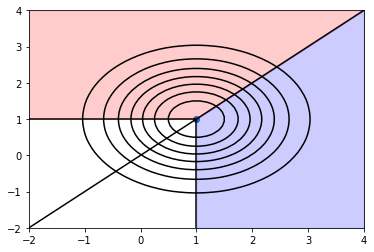

In [173]:
plot_visual_integrate(mu_x =1.0, mu_y = 1.0,
                       sig_x = 1.0, sig_y =1.0)

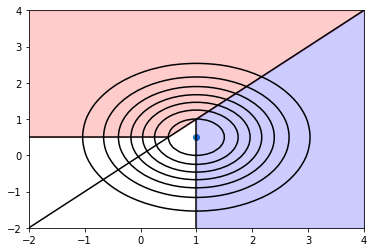

In [174]:
plot_visual_integrate(mu_x =1.0, mu_y = 0.5,
                       sig_x = 1.0, sig_y =1.0)

As you can see, in both of these cases more than 50% of the density is within the red or blue regions. When I do the intergration below, these are the sections that I intergrate over.

If we increase the expected value of action 0 and decrease the expected value of action 1 further, we see that we tend towards 50% overestimation as expected.

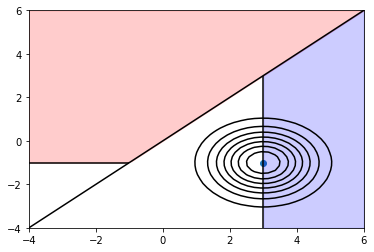

In [175]:
plot_visual_integrate(mu_x =3.0, mu_y = -1.0,
                       sig_x = 1.0, sig_y =1.0,
                       xlims = (-4,6), ylims = (-4,6))

Ok, let's do this integration.

In [176]:
def multi_norm(y,x, mu_x, mu_y,sig_x, sig_y):

  first = 1/(sig_x*sig_y*2*np.pi)
  second = np.exp(-0.5*((x-mu_x)/sig_x)**2)
  third = np.exp(-0.5*((y-mu_y)/sig_y)**2)

  return first*second*third


def theoretical_overestimation_2D(mu_x, mu_y,sig_x, sig_y, n = 2):

  sig_x, sig_y = np.sqrt(sig_x)/np.sqrt(n), np.sqrt(sig_y)/np.sqrt(n) # Expected error in estimating population mean from sample mean


  # Find Probabilty of selecting action 0 and overestimating
  R0,_ =integrate.dblquad(multi_norm,
                          mu_x, np.inf, # limits of x
                          lambda x: -np.inf, lambda x: x, # limits of y
                          args = (mu_x, mu_y,sig_x, sig_y,) 
                           )
  # Find Probabilty of selecting action 1 and overestimating
  R1,_ =integrate.dblquad(multi_norm,
                          mu_y, np.inf, 
                          lambda x: -np.inf, lambda x: x, 
                          args = (mu_y, mu_x,sig_y, sig_x,)
                          )
  return {'Probabilty of selecting action 0 and overestimating' : R0,
          'Probabilty of selecting action 1 and overestimating' : R1,
          'Probabilty of overestimating': R0+R1}



Let's predict using this integral the probability of overestimation. We'll do one case with equal means (should be 75% overestimation) and one with unequal means. 

Standard deviation of 1.0 for each.

In [177]:
mu_x, mu_y,sig_x, sig_y = 1.0, 1.0, 1.0, 1.0
output_dict = theoretical_overestimation_2D(mu_x, mu_y,sig_x, sig_y, num_samples)
for k,v in output_dict.items():
  print(f'{k}: {v}')

Probabilty of selecting action 0 and overestimating: 0.37500000000360406
Probabilty of selecting action 1 and overestimating: 0.37500000000360406
Probabilty of overestimating: 0.7500000000072081


In [178]:
mu_x, mu_y,sig_x, sig_y = 1.0, 0.5, 1.0, 1.0
output_dict = theoretical_overestimation_2D(mu_x, mu_y,sig_x, sig_y, num_samples)
for k,v in output_dict.items():
  print(f'{k}: {v}')

Probabilty of selecting action 0 and overestimating: 0.4913175114367623
Probabilty of selecting action 1 and overestimating: 0.12309375010624006
Probabilty of overestimating: 0.6144112615430023


 We can validate this empirically through simulation. The simulation plot will show three subplots:


1.   Predicted expected value for each actions for when they are selected as optimal.
2.   Histogram of the number of simulations in which the selector selected actions as optimal.
3. Variance of the predicted expected value for each actions for when they are selected as optimal, expressed as a percentage of expected variance.



In [179]:
def simulate_plot(data_generator, selector, iterations = 10_000):
  store = np.zeros((iterations, 3))
  for iter in range(iterations):
    samples = data_generator.generate(num_samples)
    pred_best_arm, pred_val = selector.select_predict(samples)
    is_over = (pred_val > data_generator.means[pred_best_arm])
    store[iter,:] = pred_best_arm, pred_val, is_over

  df = pd.DataFrame(data = store, columns=['Chosen_arm', 'Predicted_val', 'Is_over'])
  pred_given_chosen = df.groupby(['Chosen_arm']).mean()
  pred_count_chosen = df.groupby(['Chosen_arm']).count()
  percentage_over = df['Is_over'].mean()
  variance = df.groupby(['Chosen_arm'])['Predicted_val'].var()
  expected_variance = np.asarray(data_generator.vars)/num_samples
  percentage_expected_variance = 100*variance/expected_variance
  

  plt.figure(1)
  plt.subplot(3,1,1)

  plt.title('Predicted values when action was predicted optimal')
  plt.scatter(jitter(store[:,0], np.size(store[:,0])), store[:,1], alpha=0.1)
  for idx in range(len(data_generator.means)):
    mean_pred_given_choosen = np.mean(store[:,1][np.where(store[:,0] == idx)])
    plt.hlines(mean_pred_given_choosen, idx-0.1, idx+0.1, colors='red')
    plt.hlines(data_generator.means[idx], idx - 0.1, idx + 0.1, colors='black')
  plt.xticks(list(range(len(data_generator.means))))

  plt.subplot(3,1,2)
  plt.title('Histogram of action being predicted optimal')
  df['Chosen_arm'].value_counts().reindex(
   list(range(data_generator.num_arms)), fill_value=0).plot(ax=plt.gca(), kind='bar')
  plt.ylim(0, iterations)

  plt.subplot(3,1,3)
  plt.title('Percentage of Expected Variance')
  percentage_expected_variance.reindex(
   list(range(data_generator.num_arms)), fill_value=0).plot(ax=plt.gca(), kind='bar')
  plt.ylim(0,150)



  plt.tight_layout()
  plt.show()



  return percentage_over

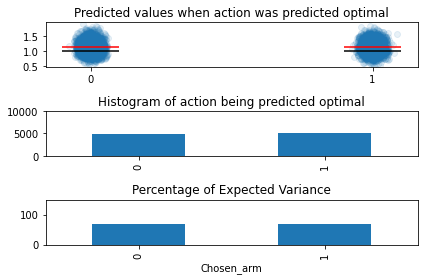

Expected value was overestimated 75.51% of the time


In [180]:
DG = DataGenerator(means=[1.0, 1.0], vars=[0.5, 0.5])
overestimation_percent = simulate_plot(DG, selector)
print(f'Expected value was overestimated {100*overestimation_percent :.2f}% of the time')

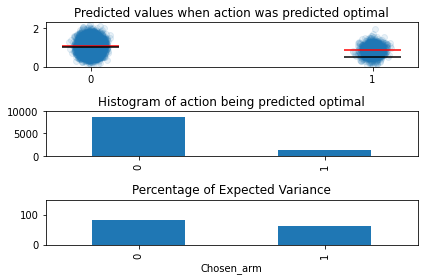

Expected value was overestimated 60.60% of the time


In [181]:
DG = DataGenerator(means=[1.0, 0.5], vars=[1.0, 1.0])
overestimation_percent = simulate_plot(DG, selector)
print(f'Expected value was overestimated {100*overestimation_percent :.2f}% of the time')

The simulation matches the prediction pretty well. I'd probably trust the simulation more, as the prediction uses a numerical integration method which may not be perfect.

This overestimation effect only gets worse for increasing numbers of trial arms. With 6 arms of equal expected value, you will overestimate 98.4% ($=1-0.5^6$) of the time! We'll show one example trial for 6 arms and then the simulation.


Under selection rule NaiveAB, for this sample we choose action 3 and predict expected value 0.296 (actions counted from 0) 


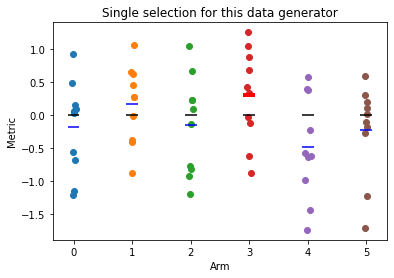

In [182]:
DG = DataGenerator(means=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], vars=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
samples = DG.generate(num_samples=num_samples)
best_arm, pred_val = selector.select_predict(samples)
print(f'Under selection rule {selector.name}, for this sample we choose action {best_arm} and predict expected value {pred_val :.3f} (actions counted from 0) ')
_ = selector.select_predict_plot(samples, DG)

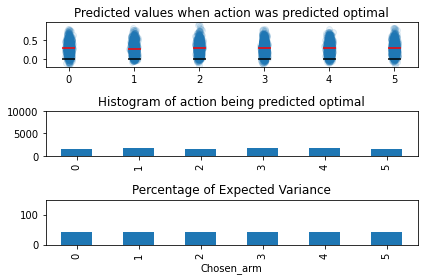

Expected value was overestimated 98.52% of the time


In [183]:
overestimation_percent = simulate_plot(DG, selector)
print(f'Expected value was overestimated {100*overestimation_percent :.2f}% of the time')

Again, we'll test 6 arm case where there is a true difference between actions in expected value.

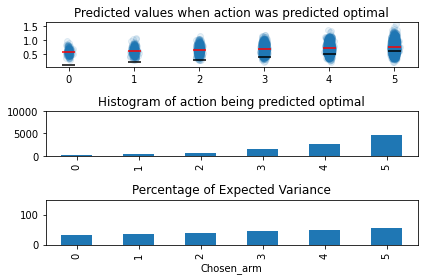

Expected value was overestimated 88.91% of the time


In [184]:
DG = DataGenerator(means=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6], vars=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
overestimation_percent = simulate_plot(DG, selector)
print(f'Expected value was overestimated {100*overestimation_percent :.2f}% of the time')

There is slightly less bias than the 'no difference' case but still there. It's especially worth noting that this overestimation bias seems to be especially bad in the cases where a suboptimal action was chosen. 

I will note that we were still typically choosing good actions though.

## Can we control for this?

Ok, I'm going to give a slight spoiler here and say that I don't think there is a silver bullet for this issue. Any methods I have tried to reduce this bias leads to a trade-off, either increasing variance (maybe bad), selecting worse actions on average (definitely bad), or some other weird effect. Still, I think it's interesting to explore some possibilities.


#### A really dumb idea
As I've noted before, this style of experimentation is good for selecting actions. Experimentation is also good under these conditions for estimating values. It's only when we try to do both that we run into issues. So as a dumb first guess, let's only do the latter. 

This selection rule, <i>'RandomMean'</i>, selects an action at random as optimal, then predicts the expected value for that action using the mean of the samples for that action. Try to take a guess what this might look like. 

In [185]:
### Feel free to change this data generator to play around, I'll mainly use this from now on
num_samples = 10
DG = DataGenerator(means=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6], vars=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

In [186]:
class RandomMean(BaseSelector):
  """
  A simple selection rule
  1. Selects a random arm as optimal
  2. Predicts the sample mean for that arm
  """
  def __init__(self, name='RandomMean'):
        super().__init__(name)
  
  def select_predict(self, samples: np.ndarray) -> (int, float):
    """
    Predicts the best arm and the value for that arm.
    """
    pred_means = np.mean(samples, axis=0) # Calculate means
    pred_best_arm = np.random.randint(0, np.shape(samples)[1] ) # Choose a random arm
    pred_val = pred_means[pred_best_arm] # Predict sample mean for selected arm 

    return pred_best_arm, pred_val

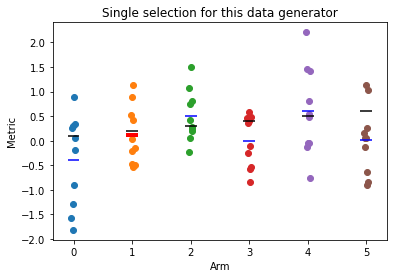

Under selection rule RandomMean, for this sample we choose action 1 and predict expected value 0.113 (actions counted from 0) 


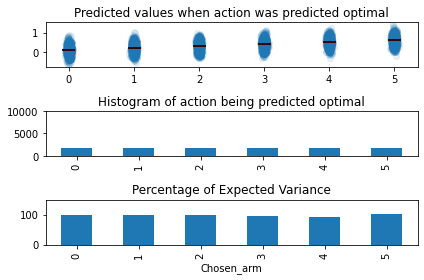

Expected value was overestimated 49.57% of the time


In [187]:
selector = RandomMean()
samples = DG.generate(num_samples=num_samples)
best_arm, pred_val = selector.select_predict_plot(samples, DG)
print(f'Under selection rule {selector.name}, for this sample we choose action {best_arm} and predict expected value {pred_val :.3f} (actions counted from 0) ')
overestimation_percent = simulate_plot(DG, selector)
print(f'Expected value was overestimated {100*overestimation_percent :.2f}% of the time')


Advantages of this (admittedly feasible) attempt.


1.   Optimistic bias is removed, estimates are unbiased

Downsides
1. Terrible at action selection, chooses the worst action as often as the best.
2. Higher variance (at the expected given the sample size)

Altogether, not recommended.



### A pooling approach

Given that the previous selection rule failed at selecting the optimal action, let's try another that predicts the best action by selecting the action with the maximum sample mean. This worked well in the NaiveAB selector.

The difference here is that we will predict the average over <b>all</b> data. Let's call this the <i>ABFullPool</i> selector ( I wonder if there is any foreshadowing here)

In [188]:
class ABFullPool(BaseSelector):
  """
  1. Selects arm with maximum sample mean
  2. Predicts the sample mean over all arms
  """
  def __init__(self, name='ABFullPool'):
        super().__init__(name)
  
  def select_predict(self, samples: np.ndarray) -> (int, float):
    """
    Predicts the best arm and the value for that arm.
    """
    pred_means = np.mean(samples, axis=0) # Calculate means
    pred_best_arm = tie_breaker(pred_means) # Best arm based on maximum mean of samples
    pred_val = np.mean(samples) # Predict the mean over samples from all arms

    return pred_best_arm, pred_val

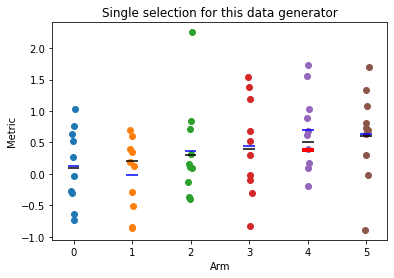

Under selection rule ABFullPool, for this sample we choose action 4 and predict expected value 0.375 (actions counted from 0) 


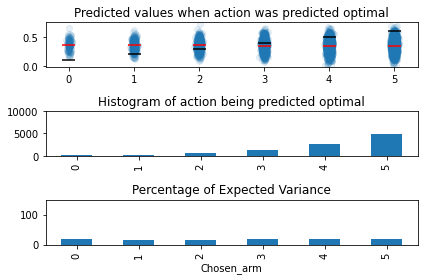

Expected value was overestimated 14.81% of the time


In [189]:
selector = ABFullPool()
samples = DG.generate(num_samples=num_samples)
best_arm, pred_val = selector.select_predict_plot(samples, DG)
print(f'Under selection rule {selector.name}, for this sample we choose action {best_arm} and predict expected value {pred_val :.3f} (actions counted from 0) ')
overestimation_percent = simulate_plot(DG, selector)
print(f'Expected value was overestimated {100*overestimation_percent :.2f}% of the time')

Advantages of this attempt.

1. Optimistic bias is removed (at least when the true best arm is selected)
2. Good action selection
3. Low variance! (Though I'm not sure that is worth celebrating)

Downsides

1. Very much introduces a different form of bias. This selector ends up with really high bias in the traditional underfitting sense. You underestimate when you choose the right action, and overestimate when you choose a bad action. I'm not sure this is an improvement. 

Again, I probably do not recommend this option (although it is quite good in the case that all the actions have the same expected value!)

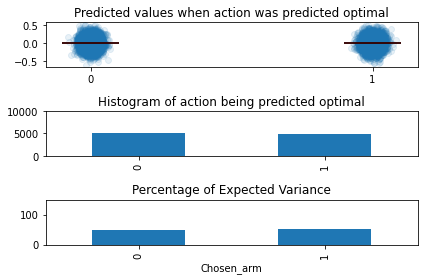

Expected value was overestimated 49.66% of the time


In [190]:
DG2 = DataGenerator(means=[0.0, 0.0], vars=[0.5, 0.5])
overestimation_percent = simulate_plot(DG2, selector)
print(f'Expected value was overestimated {100*overestimation_percent :.2f}% of the time')

### Statistics to the rescue(?)

As you've been reading this, you've potentially been thinking that when we conduct A/B tests we often conduct hypothesis tests to assess whether there is evidence to support one action being better than another. Let's try to use an approach that leverages that. 

This next selector is similar to the ABFullPool selector, except instead of pooling over all arms, we discard data from the arms that we can determine are 'statistically different' to the arm predicted optimal. 

 Let's call this the <i>ABPartialPool</i> selector (Foreshadowing achieved)

In [191]:
class ABPartialPool(BaseSelector):
  """
  1. Chooses arm with maximum sample mean
  2. Predicts the mean for that arm as the sample mean of all 'similar' arms.
  """
  def __init__(self, name='ABPartialPool', alpha = 0.05):
        super().__init__(name)
        self.alpha = alpha # Threshold for discarding data
  
  def select_predict(self, samples: np.ndarray) -> (int, float):
    """
    Predicts the best arm and the value for that arm.
    """
    pred_means = np.mean(samples, axis=0) # Calculate means

    pred_best_arm = tie_breaker(pred_means)

    # Hyptothesis testing
    pred_best_mean_naive = pred_means[pred_best_arm] 
    pred_stds = samples.std(axis=0)
    pred_best_std = pred_stds[pred_best_arm]

    numerator = pred_best_mean_naive - pred_means - 0
    denominator = np.sqrt((pred_stds ** 2 + pred_best_std ** 2)/(samples.shape[0]))
    z = numerator/denominator
    p = scipy.stats.norm.sf(abs(z))
    to_include = p>self.alpha

    pred_val = np.sum(pred_means*to_include)/to_include.sum() # prediction is the average of doses
    # not sig diff at alpha = alpha


    return pred_best_arm, pred_val

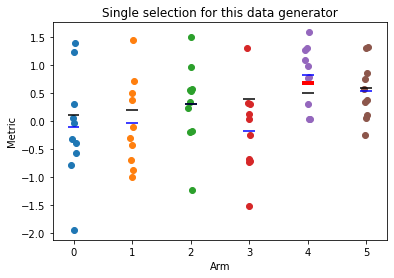

Under selection rule ABPartialPool, for this sample we choose action 4 and predict expected value 0.681 (actions counted from 0) 


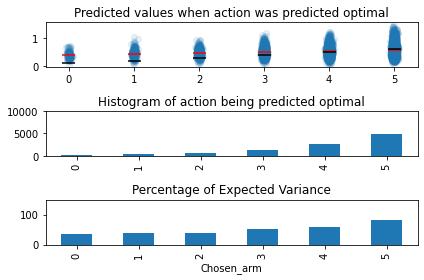

Expected value was overestimated 51.66% of the time


In [192]:
selector = ABPartialPool()
samples = DG.generate(num_samples=num_samples)
best_arm, pred_val = selector.select_predict_plot(samples, DG)
print(f'Under selection rule {selector.name}, for this sample we choose action {best_arm} and predict expected value {pred_val :.3f} (actions counted from 0) ')
overestimation_percent = simulate_plot(DG, selector)
print(f'Expected value was overestimated {100*overestimation_percent :.2f}% of the time')

We can change the value of <i>alpha</i> to change how much evidence is needed to discard a group. Increasing alpha leads to more actions being considered 'statistically different', tending to the NaiveAB selector as alpha tends to 0.5. Decreasing alpha means more data is needed to consider actions to be different, leading to the ABFullPool as alpha tends to 0.0.

----------------------Alpha = 0.005-------------------------------------------------


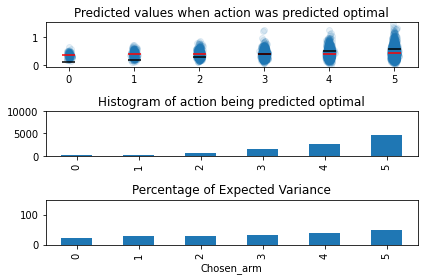

Expected value was overestimated 29.05% of the time
----------------------Alpha = 0.05-------------------------------------------------


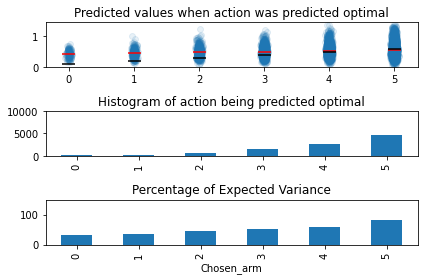

Expected value was overestimated 51.94% of the time
----------------------Alpha = 0.4-------------------------------------------------


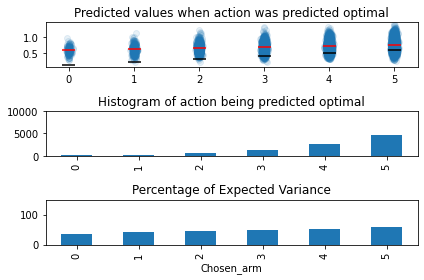

Expected value was overestimated 87.65% of the time


In [193]:
print(f'----------------------Alpha = 0.005-------------------------------------------------')
selector = ABPartialPool(alpha=0.005)
overestimation_percent = simulate_plot(DG, selector)
print(f'Expected value was overestimated {100*overestimation_percent :.2f}% of the time')
print(f'----------------------Alpha = 0.05-------------------------------------------------')
selector = ABPartialPool(alpha=0.05)
overestimation_percent = simulate_plot(DG, selector)
print(f'Expected value was overestimated {100*overestimation_percent :.2f}% of the time')
print(f'----------------------Alpha = 0.4-------------------------------------------------')
selector = ABPartialPool(alpha=0.4)
overestimation_percent = simulate_plot(DG, selector)
print(f'Expected value was overestimated {100*overestimation_percent :.2f}% of the time')

Advantages of this attempt.

1. Optimistic bias is removed (at least when the true best arm is selected)
2. Good action selection

Downsides

1. Optimistic bias still present when a sub-optimal action is selected
2. Slight underestimation when true optimal action is selected
3. Requires selection of alpha as a hyperparamter.

I think this is maybe a step forward. Out of all the options so far this is the best I think. This definitely feels like a useful heuristic rather than a formal solution, but I'm relatively fond of this. Good job, stats!

# Answering two questions with two datasets

As I suggested before, the issue arises from using the same data to both select an optimal action and predict the value of that action. We can avoid this by not doing that, and instead splitting our data into two halves (which do not need to be equal in size. The first half is used for selection, the second half is used for prediction. 

I'm somewhat inspired in this by the concept of 'double-Q learning' in reinforcement learning, in which two models are trained on a data set by splitting the data.

It might also be reasonable to conceptualise this as holding out a validation set.

In [194]:
class SplitAB(BaseSelector):
  """
  1. Splits the data set
  2. Calculate the sample means for each arm using dataset 1.
  3. Use this to select the 'optimal' action.
  4. Calculate the sample means for each arm using dataset 2.
  5. Predict the expected value of the selected arm using as the dataset 2 sample mean for that arm.
  """
  def __init__(self, name='SplitAB', select_prop = 0.50):
        super().__init__(name)
        self.select_prop = select_prop # Proportion of data used for selection
  
  def select_predict(self, samples: np.ndarray) -> (int, float):
    """
    Predicts the best arm and the value for that arm.
    """
    # Split data
    num_samples_top = ceil(np.shape(samples)[0] * self.select_prop)
    top = samples[:num_samples_top, :]
    bottom = samples[num_samples_top:, :]

    # Select best using first fold
    pred_means_select = np.mean(top, axis=0)
    pred_best_arm = tie_breaker(pred_means_select)

    # Predict value using second fold
    pred_means_predict = np.mean(bottom, axis=0)
    pred_val = pred_means_predict[pred_best_arm]

    return pred_best_arm, pred_val

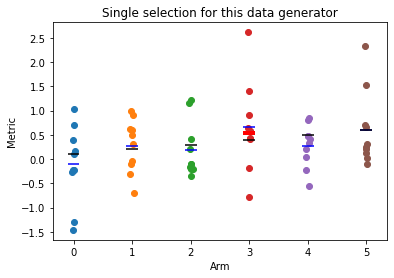

Under selection rule SplitAB, for this sample we choose action 3 and predict expected value 0.529 (actions counted from 0) 


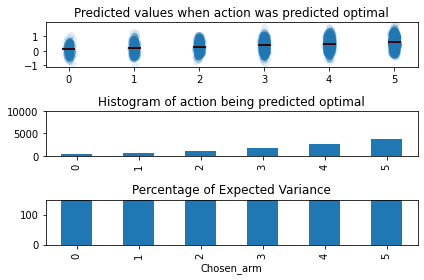

Expected value was overestimated 49.59% of the time


In [195]:
selector = SplitAB()
samples = DG.generate(num_samples=num_samples)
best_arm, pred_val = selector.select_predict_plot(samples, DG)
print(f'Under selection rule {selector.name}, for this sample we choose action {best_arm} and predict expected value {pred_val :.3f} (actions counted from 0) ')
overestimation_percent = simulate_plot(DG, selector)
print(f'Expected value was overestimated {100*overestimation_percent :.2f}% of the time')

We can change the value of <i>select_prop</i> to change the proportion of data used for selection and for prediction. Increasing <i>select_prop</i> leads to better action selection, but greater prediction variance. Decreasing <i>select_prop</i> leads to a better estimation of the expected value of the selected action, but a greater probability of selecting a suboptimal action.

----------------------Selection Percentage = 0.3-------------------------------------------------


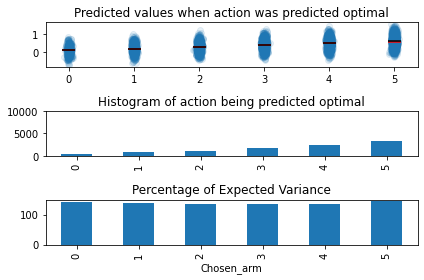

Expected value was overestimated 50.53% of the time
----------------------Selection Percentage = 0.5-------------------------------------------------


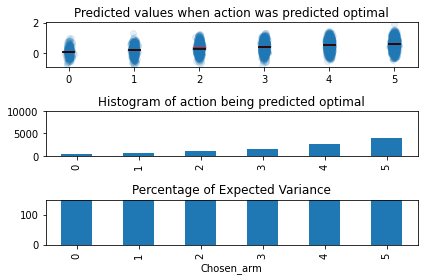

Expected value was overestimated 49.84% of the time
----------------------Selection Percentage = 0.8-------------------------------------------------


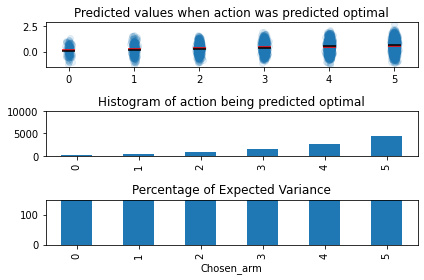

Expected value was overestimated 49.91% of the time


In [196]:
print(f'----------------------Selection Percentage = 0.3-------------------------------------------------')
selector = SplitAB(select_prop=0.3)
overestimation_percent = simulate_plot(DG, selector)
print(f'Expected value was overestimated {100*overestimation_percent :.2f}% of the time')
print(f'----------------------Selection Percentage = 0.5-------------------------------------------------')
selector = SplitAB(select_prop=0.5)
overestimation_percent = simulate_plot(DG, selector)
print(f'Expected value was overestimated {100*overestimation_percent :.2f}% of the time')
print(f'----------------------Selection Percentage = 0.8-------------------------------------------------')
selector = SplitAB(select_prop=0.8)
overestimation_percent = simulate_plot(DG, selector)
print(f'Expected value was overestimated {100*overestimation_percent :.2f}% of the time')

Advantages of this attempt.

1. Optimistic bias is removed for all actions.

Downsides

1. Data is wasted here, leading to downsides 2 and 3.
2. Worse action selection than NaiveAB.
3. There is an increase in variance regarding estimation of the value of the predicted optimal action. 
4. Requires selection of <i>selection_prop</i> as a hyperparameter.


Obviously, there is wasted data here. It would probably be cheaper to do these two splits in two experiments. First, run one experiment using only the test_perc % of the data to select the 'optimal' action, then run a second on only the selected action to estimate the value of that action. I'd argue that this is likely the 'correct' answer to this question, but requires a slightly more complicated experimental design.

In some cases, this approach may be reasonable



### True Double-Q
As stated, the above approach was inspired by the ideas of double-q learning in that effectively two 'estimators' are 'trained' (one for selection, one for prediction).

I thought it might be worth investigating the traditional double-q method. Here again two 'estimators' are 'trained', then we create a meta-estimator by taking the minimum prediction for each arm over these two estimators. This meta-estimator is used for selection and prediction.

In [197]:
class DoubleQ(BaseSelector):
  """
  1. Splits the data set.
  2. Calculate the sample means for each arm using dataset 1.
  3. Calculate the sample means for each arm using dataset 2.
  4. Take the minimum sample mean of each arm over these two vectors .
  5. Select the optimal arm using the maximum of the minimums.
  6. Predict the expected value of the selected arm as that maximum minimum
  """
  def __init__(self, name='DoubleQ'):
        super().__init__(name)
        
  
  def select_predict(self, samples: np.ndarray) -> (int, float):
    """
    Predicts the best arm and the value for that arm.
    """
    # Split data
    num_samples_top = ceil(np.shape(samples)[0] * 0.5)
    top = samples[:num_samples_top, :]
    bottom = samples[num_samples_top:, :]

    # Select best using first fold
    pred_means_1 = np.mean(top, axis=0)
    pred_means_2 = np.mean(bottom, axis=0)
    stack = np.stack((pred_means_1,pred_means_2))
    double_q = np.min(stack, axis = 0)
    pred_best_arm = tie_breaker(double_q)

    # Predict value using double_q
    pred_val = double_q[pred_best_arm]

    return pred_best_arm, pred_val

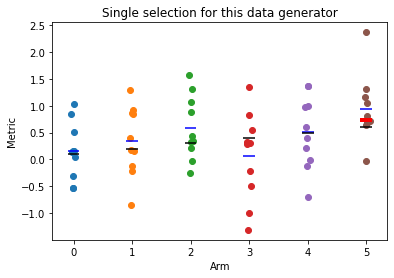

Under selection rule DoubleQ, for this sample we choose action 5 and predict expected value 0.738 (actions counted from 0) 


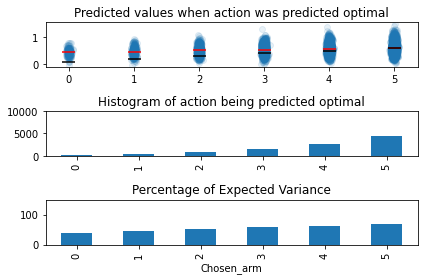

Expected value was overestimated 64.95% of the time


In [198]:
selector = DoubleQ()
samples = DG.generate(num_samples=num_samples)
best_arm, pred_val = selector.select_predict_plot(samples, DG)
print(f'Under selection rule {selector.name}, for this sample we choose action {best_arm} and predict expected value {pred_val :.3f} (actions counted from 0) ')
overestimation_percent = simulate_plot(DG, selector)
print(f'Expected value was overestimated {100*overestimation_percent :.2f}% of the time')

Advantages of this attempt.

1. Optimistic bias is removed when the true optimal action is selected.
2. Still good action selection
3. Variance not increased dramatically

Downsides

1. There is still an overestimation bias when a subo-ptimal action is selected.

Again, I actually think that this selector was surprisingly good, though it does intuitively feel more like a heuristic than a true solution.



### Stein estimation

'Shrinkage' is a really interesting statistical topic that takes some getting your head around. A basic concept of one idea of shrinkage is that is your attempt to estimate the mean values of 3 or more populations using the sample means of each, you end up with a biased estimate. 

James and Stein suggested an estimator which was less bias, called the James-Stein estimator. Broadly, this 'moves' the prediction away from the sample means and towards the global mean over all arms*.  See http://bayesianthink.blogspot.com/2016/05/the-james-stein-estimator.html for a good explanation

Now note that this is not exactly our case (our bias is observable with two or more arms, not three or more.) Nonetheless, moving towards the global mean feels potentially promising as an idea. 

* Note that we can move away from the sample mean towards any point, but the global means feels most reasonable to me

In [199]:
class SteinAB(BaseSelector):
  """
  A simple selection rule
  1. Chooses arm with maximum sample mean
  2. Predicts the sample mean for that arm
  """
  def __init__(self, name='SteinAB', select_prop = 0.50):
        super().__init__(name)
        self.select_prop = select_prop # Proportion of data used for selection
  
  def select_predict(self, samples: np.ndarray) -> (int, float):
    """
    1. Selects the best arm and the value for that arm.
    2. Prediction is based on the James-Stein shrinkage estimator
    """
    pred_means = np.mean(samples, axis=0) # Calculate means


    pred_best_arm = tie_breaker(pred_means)

    global_mean = np.mean(samples)
    global_variance = np.var(samples)/np.size(samples)
    num_samples, num_arms = np.shape(samples)
    
    cval = 1 - ((num_arms - 2)*global_variance/np.sum((global_mean - pred_means)**2))
    jsest = global_mean + cval * (pred_means - global_mean)

    pred_val = jsest[pred_best_arm]

    return pred_best_arm, pred_val

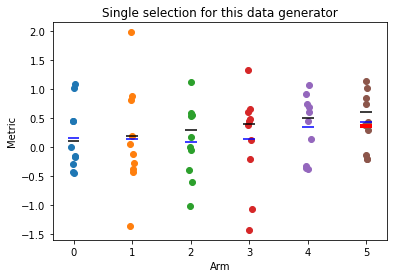

Under selection rule SteinAB, for this sample we choose action 5 and predict expected value 0.368 (actions counted from 0) 


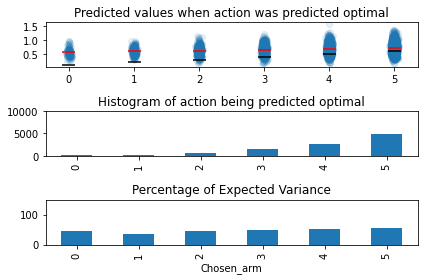

Expected value was overestimated 83.70% of the time


In [200]:
selector = SteinAB()
samples = DG.generate(num_samples=num_samples)
best_arm, pred_val = selector.select_predict_plot(samples, DG)
print(f'Under selection rule {selector.name}, for this sample we choose action {best_arm} and predict expected value {pred_val :.3f} (actions counted from 0) ')
overestimation_percent = simulate_plot(DG, selector)
print(f'Expected value was overestimated {100*overestimation_percent :.2f}% of the time')

As a quick comparison to the NaiveAB, we do see a slight improvement.

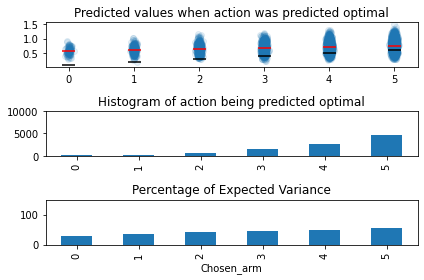

Expected value was overestimated 88.79% of the time


In [201]:
selector = NaiveAB()
overestimation_percent = simulate_plot(DG, selector)
print(f'Expected value was overestimated {100*overestimation_percent :.2f}% of the time')

Advantages of this attempt.

1. Slight reduction in bias when the true optimal action is selected.
2. Still good action selection
3. Variance not increased dramatically

Downsides

1. There is still an overestimation bias for all arms.
2. The concepts behind this have very much been tacked on to this problem. Whilst shrinkage may be a related concept, I think that selection bias is likely the main cause of bias here rather than the Stein paradox. 


# Summary
I certainly found this an interesting investigation, and wonder if anyone else has already found a good solution.


1. Be cautious in stating predictions when conducting A/B tests.
2. Be even more cautious if you have a large number of arms and your experimental results showed similar expected values (or you have prior reason to expect similar expected values).
3. As a logical consequence, when designing experiments, be cautious in adding experimental arms that you expect to be similar in expected value to the arm you expect to be the best. 
4. The ABPartialPool, SplitAB, DoubleQ, and Stein selectors might be reasonable considerations. All have advantages and downsides. ABPartialPool and Stein seem the most parsimonious to me.
5. Doing a validation experiment  to estimate value after the first A/B test seems to be a reasonable idea if possible.

Ultimately if you are using only a small number of arms in your A/B tests and are using a sufficiently large sample size relative and/or there is a large difference in expected value between the actions then this might not be worth worrying about. But in the case where we are running expensive ML experiments so we must make do with with very few samples, we should potentially be cautious. 

I note that whilst I have considered maximisation of continuous outcome variables here to make the maths simpler, the same effect occurs for maximising the probability of binary outcomes.